# Lompe example - HiLDA event

Produce figures from the HiLDA event 17 August 2001. The first figure will show the Lompe output when given observations of ionospheric electrodynamics from *SuperMAG* (horizontal ground magnetic field perturbations) and *SuperDARN* (line-of-sight plasma convection measurements). *IMAGE WIC* is used to estimate auroral conductance. Solar conductance is calcualted by the method described in the Lompe paper ([Laundal et al. 2022](https://doi.org/10.1029/2022JA030356)). The second figure shows data distribution and a comparison of the modelled magnetic field perturbations from Lompe compared to mesurements from *Champ*.

*Change note (August 2022)*: This notebook has been updated to use vector summation of EUV and auroral conductances instead of linear summation. Therefore, the output figures are slightly different from the figures in the paper.

We start by loading the relevant modules:

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import lompe
from apexpy import Apex
from scipy.interpolate import interp1d, griddata
from lompe.utils.geodesy import geoc2geod
from ppigrf import igrf_gc
from lompe.polplot import Polarplot
from lompe import visualization
from lompe.utils import sunlight
from lompe.utils.conductance import EUV_conductance
import cdflib # to read Champ data file

Specify paths for example data files.  For this example, the files are pre-made and saved in *./sample_dataset*. See Data_handling_with_Lompe for explanation on how to get the data on this format. 

In [2]:
event = '2001-08-17'

wicfn = '../sample_dataset/20010817_wic_image.nc'
supermagfn = '../sample_dataset/20010817_supermag.h5'
champfn = '../sample_dataset/20010817_champ_magnetic_field.cdf'
sdarnfn = '../sample_dataset/20010817_superdarn_grdmap.h5'

##### Conductance from WIC

Global images of the aurora from the IMAGE satellite is used to estimate auroral conductances. Get WIC (Wide-field Imaging Camera) data and calculate conductance:

In [3]:
ds = xr.open_dataset(wicfn)

EE  = np.array([0.2, 0.5, 1.0, 5.0, 10.0, 25.0])
E1  = np.array([446, 470, 511, 377, 223, 101])
fE1 = interp1d(EE, E1, fill_value = (446, 101), bounds_error = False)

assumed_mean_energy = 2.56 # keV
ds['eFlux'] = ds['shimage'] / fE1(assumed_mean_energy)
ds['eFlux'].attrs = {'long_name' : 'Energy flux', 'units' : '$mW/m^2$'}
ds['eFlux'] = ds['eFlux'].clip(0, None)      # set negatives to zero

# use Robinson formulae to calculate conductances
ds['SPedersen'] = 40 * assumed_mean_energy / (16 * assumed_mean_energy**2) * np.sqrt(ds['eFlux'])
ds['SHall'] = 0.45 * assumed_mean_energy ** 0.85 * ds['SPedersen']

Use the WIC image time to specify time interval used for model:

In [4]:
DT = dt.timedelta(seconds = 60*4) # model a four minute time interval
date = pd.to_datetime(ds.date.values)

# model time interval
t0 = date - DT/2
t1 = date + DT/2
print('Model interval is ' + str(t0) + ' UT to ' + str(t1) + ' UT')

Model interval is 2001-08-17 16:27:14 UT to 2001-08-17 16:31:14 UT


##### Grid

We set up a cubed spehere grid for the image and one for the model

In [5]:
# grid specs
L, W, Lres, Wres = 6000.e3, 3000.e3, 75.e3, 75.e3 # dimensions and resolution of grid, in meters
pos = (0, 90)  # defualt center of cubed sphere grid
CENTER_IN_SPOT = True # will center grid in designated spot

# apex object for coordinate systems
a = Apex(date = date.year)

if CENTER_IN_SPOT:
    # find the geographic coordinate of the spot
    mlat = 78
    mlt  = 16.5

    mlon = a.mlt2mlon(mlt, date)
    glat, glon, error = a.apex2geo(mlat, mlon, 130)
    print('grid lat, lon :', glat, glon)
    pos = (glon, glat)
p = lompe.cs.CSprojection(pos, 20)

# image grid
imgrid = lompe.cs.CSgrid(p, L, W, Lres, Wres, R = (6371.2 + 110)*1e3)

grid lat, lon : 75.69322204589844 -31.540376663208008


We interpolate the WIC image and derived conductances on the cubed sphere grid (imgrid)

In [6]:
lon, lat = ds.glon.values.flatten(), ds.glat.values.flatten()
SH_num = ds['SHall'    ].values.flatten()
SP_num = ds['SPedersen'].values.flatten()

iii = imgrid.ingrid(lon, lat, ext_factor = 1.3)

xi, eta = p.geo2cube(lon[iii], lat[iii])

# interpolate pixels to the grid:
SH_grd = griddata(np.vstack((xi, eta)).T, SH_num[iii], np.vstack((imgrid.xi.flatten(), imgrid.eta.flatten())).T).reshape(imgrid.shape)
SP_grd = griddata(np.vstack((xi, eta)).T, SH_num[iii], np.vstack((imgrid.xi.flatten(), imgrid.eta.flatten())).T).reshape(imgrid.shape)

# make a function that picks values from the right grid cell
def get_conductance(lon, lat, time, type = 'Hall'):
    shape = lon.shape
    if type == 'Hall':
        C = SH_grd
    if type == 'Pedersen':
        C = SP_grd

    sza = sunlight.sza(lat.flatten(), lon.flatten(), time)
    
    i, j = imgrid.bin_index(lon.flatten(), lat.flatten())
    conductance = np.sqrt(C[i, j].flatten()**2 + EUV_conductance(sza, 100, type[0].lower())**2)
    
    return conductance.reshape(shape)

# construct tuple of Hall / Pedersen functions to pass to lompe Emodel object:
conductances = (lambda lon, lat : get_conductance(lon, lat, t0, type = 'Hall'),
                lambda lon, lat : get_conductance(lon, lat, t0, type = 'Pedersen'))

/Users/laundal/Dropbox/git/lompe/secsy/secsy/cubedsphere.py:196: RuntimeWarning: invalid value encountered in cos
  r = np.vstack((np.cos(lat) * np.cos(lon),
/Users/laundal/Dropbox/git/lompe/secsy/secsy/cubedsphere.py:197: RuntimeWarning: invalid value encountered in cos
  np.cos(lat) * np.sin(lon),
/Users/laundal/Dropbox/git/lompe/secsy/secsy/cubedsphere.py:197: RuntimeWarning: invalid value encountered in sin
  np.cos(lat) * np.sin(lon),
/Users/laundal/Dropbox/git/lompe/secsy/secsy/cubedsphere.py:198: RuntimeWarning: invalid value encountered in sin
  np.sin(lat)))


We then set up model grid and plot it on map. This grid covers an area over Greenland.

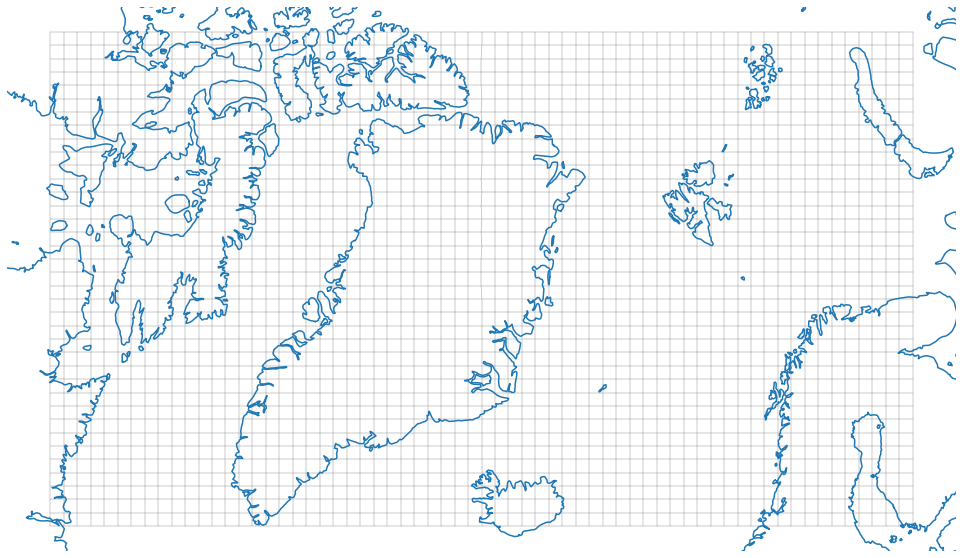

In [7]:
# create grid object
grid = lompe.cs.CSgrid(p, L, W, Lres, Wres, R = (6371.2 + 110)*1e3)

# plot grid and coastlines
fig, ax = plt.subplots(figsize = (17, 10))
ax.set_axis_off()
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color = 'C0')
    
ax.set_xlim(xlim)
ax.set_ylim(ylim);

##### Input data

The inout data must be passed to the lompe Emodel object (created later) as Lompe Data objects. The data that is passed to the Emodel object is the data that will be used in the inversion. However, the data objects above contain data from a whole day (17 August 2001).

In [8]:
def get_data_subsets(t0, t1):
    """ return subsets of data loaded above, between t0 and t1 """

    # SuperMAG data:
    smag = supermag.loc[t0:t1, :]
    smag_B = np.vstack((smag.Be.values, smag.Bn.values, smag.Bu.values))
    smag_coords = np.vstack((smag.lon.values, smag.lat.values))
    
    # SuperDARN data:
    sd = superdarn # the file contains data only from the correct time interval, no time selection needed
    vlos = sd['v'].values     # this is median value in gridded obs.
    sd_coords = np.vstack((sd['glon'].values, sd['glat'].values))
    los  = np.vstack((sd['le'].values, sd['ln'].values))
    sd_err = sd['std']           # standard deviation as error
    
    # Make the data objects. The scale keyword determines a weight for the dataset. Increase it to reduce weight
    supermag_data  = lompe.Data(smag_B * 1e-9, smag_coords,            datatype = 'ground_mag', scale = 100e-9)
    superdarn_data = lompe.Data(vlos         , sd_coords  , LOS = los, datatype = 'convection', scale = 500 )
    
    return supermag_data, superdarn_data

The SuperDARN file for 17 August 2001 contains only magnetic coordinates and line-of-sight components. We therefore need a function to add geographic components:

In [9]:
def superdarn_fix(superdarn):
    ''' Add geographic components to superDARN data set.'''
    
    SDmlat  = superdarn['mlat'].values
    SDmlon  = superdarn['mlon'].values
    bearing = superdarn['bearing'].values

    # convert to geographic coordinates
    SDglat, SDglon, _ = a.apex2geo(SDmlat, SDmlon, 110)
    
    # line-of-sight vector components, in magnetic AACGM
    le_m, ln_m = np.sin(bearing * np.pi / 180), np.cos(bearing * np.pi / 180)
    
    # find bearing angle in geographic
    f1, f2 = a.basevectors_qd(SDglat, SDglon, 110) # vectors pointing roughly east, north AACGM
    
    # normalize the northward vector, and define a new eastward vector that is perpendicular:
    f2 = f2 / np.linalg.norm(f2, axis = 0)
    f1 = np.cross(np.vstack((f2, np.zeros(f2.shape[1]))).T, np.array([[0, 0, 1]])).T[:2]
    
    # line of sight vector components in geographic
    le, ln = f1 * le_m + f2 * ln_m
    
    superdarn['glat'], superdarn['glon'] = SDglat, SDglon
    superdarn['le'], superdarn['ln'] = le, ln
    
    return superdarn

Load the data sets, get correct time interval and Lompe-objects:

In [10]:
# load data
superdarn = pd.read_hdf(sdarnfn)
supermag = pd.read_hdf(supermagfn)

# correct superdarn data
superdarn = superdarn_fix(superdarn)

# get correct time
supermag_data, superdarn_data = get_data_subsets(t0, t1)

##### Set up model and run inversion
Now we have everything we need to set up the Lompe Emodel, add data, and run the inversion for the electric field.

In [11]:
model = lompe.Emodel(grid, Hall_Pedersen_conductance = conductances)
model.add_data(supermag_data, superdarn_data)

# Run inversion. l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction
model.run_inversion(l1 = 1, l2 = 10);

Before we plot the output, load CHAMP data, so that the orbit can be included in the Lompe plot

##### Comparison with *Champ*
Make a plot that compares CHAMP data to lompe inversion result:

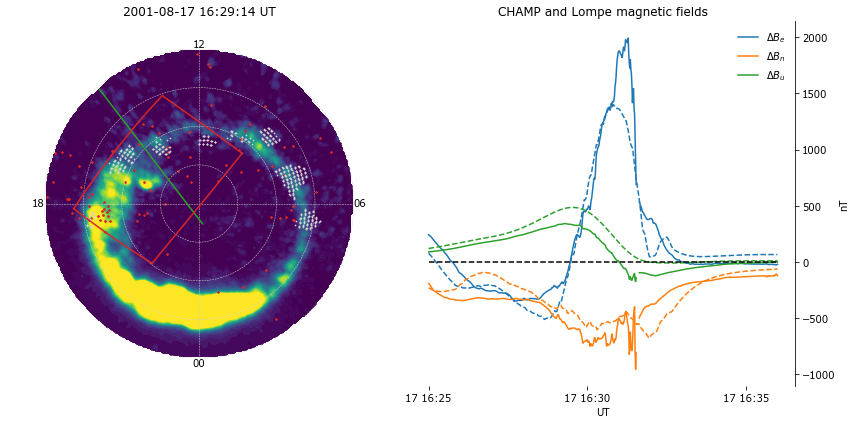

In [12]:
cdf = cdflib.CDF(champfn)
mag = cdf['NEC_VEC'] # space magnetometer data

# geocentric coords of CHAMP orbit
theta = 90 - cdf['GEO_LAT']
phi   = cdf['GEO_LON']
r     = cdf['GEO_ALT'] + 6371.2

time = cdflib.epochs.CDFepoch.to_datetime(cdf.varget('EPOCH')) 

# using IGRF to calculate magntic disturbance (dB) registered by CHAMP
Br, Btheta, Bphi = igrf_gc(r, theta, phi, time[0])
B0 = np.vstack((-Btheta.flatten(), Bphi.flatten(), -Br.flatten()))
dB = mag.T - B0

champ_df = pd.DataFrame({'Be':dB[1], 'Bn':dB[0], 'Br':-dB[2], 'lon':phi, 'lat':90 - theta, 'r':r*1e3}, index = time)['2001-08-17 16:25':'2001-08-17 16:35']

# convert CHAMP coords to geodetic
ch_gdlat, ch_h, ch_Bn, ch_Bz = geoc2geod(90 - champ_df['lat'], champ_df['r'] * 1e-3, -champ_df['Bn'], champ_df['Br'])
Be, Bn, Bu = model.B_space(champ_df['lon'].values, ch_gdlat, ch_h * 1e3 + 6371.2e3)


# plot comparing modelled dB to CHAMP measurements
fig, axes = plt.subplots(ncols = 2, figsize = (12, 6))

# Champ magnetic disturbance observations (east, north, up) in solid lines
# lompe magnetic disturbances along Champ trajectory (east, north, up) in dashed lines
axes[1].plot(champ_df.index, champ_df['Be'], color = 'C0', label = r'$\Delta B_e$')
axes[1].plot(champ_df.index, Be * 1e9, color = 'C0', linestyle = '--')

axes[1].plot(champ_df.index, ch_Bn, color = 'C1', label = r'$\Delta B_n$')
axes[1].plot(champ_df.index, Bn * 1e9, color = 'C1', linestyle = '--')

axes[1].plot(champ_df.index, -ch_Bz, color = 'C2', label = r'$\Delta B_u$')
axes[1].plot(champ_df.index, Bu * 1e9, color = 'C2', linestyle = '--')

# axis labels and lines
axes[1].legend(frameon = False)
axes[1].yaxis.set_label_position("right")
axes[1].spines['left'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')
axes[1].set_ylabel('nT')
axes[1].set_xlabel('UT')
axes[1].set_title('CHAMP and Lompe magnetic fields')
axes[1].plot(champ_df.index, Bu*0, 'k--')
axes[1].yaxis.tick_right()

# add plot to show data coverage and CHAMP orbit
pax = Polarplot(axes[0])

x, y = pax._latlt2xy(ds['mlat'].values.flatten(), ds['mlt'].values.flatten())
xx, yy = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(-1, 1, 200))

# plotting IMAGE WIC used for conductance
im = ds['shimage'].values.flatten()
iii = (x**2 + y**2) <= 1
image = griddata(np.vstack((x[iii], y[iii])).T, im[iii], np.vstack((xx.flatten(), yy.flatten())).T)
pax.ax.contourf(xx, yy, image.reshape((200, 200)), levels = np.linspace(0, 3000, 25), extend = 'both')

# plot CHAMP orbit as green line - but must convert to apex first
mlat, mlon = a.geo2apex(ch_gdlat, champ_df['lon'], ch_h)
mlt = np.array([a.mlon2mlt(ml, t) for ml, t in zip(mlon, champ_df.index.to_pydatetime())])
pax.plot(mlat, mlt, color = 'C2')

# plot lompe grid - but project to apex first
lats = [grid.lat[0, :], grid.lat[-1, :], grid.lat[:, 0], grid.lat[:, -1]]
lons = [grid.lon[0, :], grid.lon[-1, :], grid.lon[:, 0], grid.lon[:, -1]]
for lon, lat, in zip(lons, lats):
    mlat, mlon = a.geo2apex(lat, lon, 110)
    mlt = a.mlon2mlt(mlon, t0)
    pax.plot(mlat, mlt, color = 'C3')

# add SuperMAG sites in red
supermag  = pd.read_hdf(supermagfn) # reload to get all
coords = supermag[t0:t1][['lat', 'lon']]
mlat, mlon = a.geo2apex(coords.lat.values, coords.lon.values, 0)
mlt = a.mlon2mlt(mlon, t0)

iii = mlat > 50 # mask sites outside of plot
pax.scatter(mlat[iii], mlt[iii], marker = '.', c = 'C3', s = 4)

# add SuperDARN backscatter in grey
pax.scatter(superdarn['mlat'].values, superdarn['mlt'].values, marker = '.', c = 'lightgrey', s = 2)

# make title for aurora plot
pax.ax.set_title(str(pd.to_datetime(ds.date.values))+' UT')
pax.writeLTlabels(lat = 50)

plt.tight_layout()

# FIGURE 9 in Lompe-paper
fig.savefig('output_figures/hilda_event_image_and_champ.pdf')

Left: The IMAGE WIC image used to estimate auroral conductance for the Lompe inversion. The red dots show SuperMAG magnetometers, and grey dots show SuperDARN backscatter locations during the four min interval used in the inversion. The red frame shows the cubed sphere grid used for the Lompe model. The green line shows the trajectory of the CHAMP satellite in a 10 min interval around the time of our analysis. 

Right: The magnetic field components measured by CHAMP (with the IGRF main magnetic field subtracted), as solid lines. The dashed lines show the Lompe magnetic field evaluated at the same coordinates. The CHAMP data was not used as input in the Lompe inversion.

We can now make the summary figure of the Lompe output using *lompe.lompeplot()*, and include the CHAMP track:

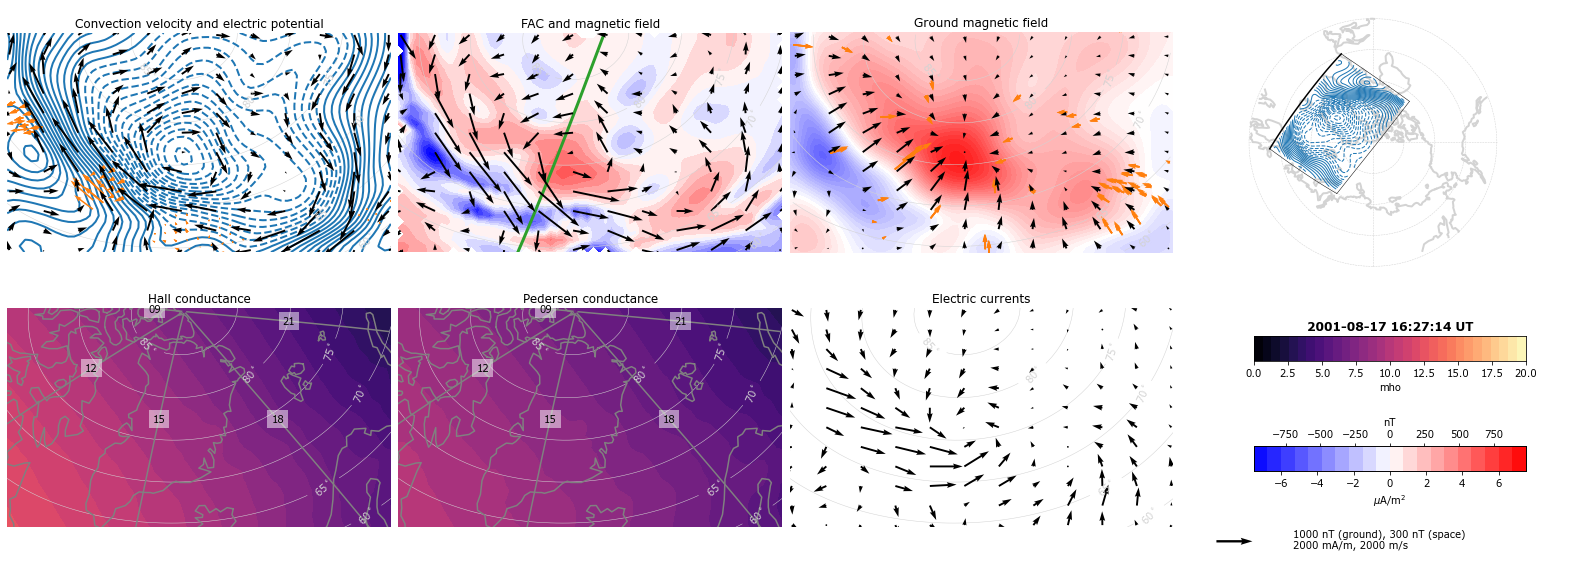

In [13]:
# FIGURE 8 in Lompe-paper
savekw = {'fname':'./output_figures/hilda_event.pdf'}
fig, axes, _, __ = lompe.lompeplot(model, include_data = True, apex = a, time = t0, 
                                   colorscales ={'fac' : np.linspace(-5, 5, 21)*1e-6*1.5, 
                                          'ground_mag' : np.linspace(-980, 980, 50) * 1e-9}, 
                                   quiverscales ={'electric_current' : 4000e-3, 
                                                  'space_mag_fac'    : 2000e-9,
                                                  'convection'       : 4000, 
                                                  'ground_mag'       : 2000e-9},
                                   return_axes = True,
                                   savekw = savekw)

# convert CHAMP track coordinates to cubedsphere coordinates:
xi, eta = p.geo2cube(champ_df['lon'], champ_df['lat'])

# plot the track in the FAC panel (and prerserve the extent):
ax = axes[0, 1]
xirange, etarange = ax.get_xlim(), ax.get_ylim()
ax.plot(xi, eta, color = 'C2', linewidth = 3)
ax.set_xlim(xirange); ax.set_ylim(etarange)
plt.savefig(**savekw)
plt.show()

##### Lompe for Joule heating
We can also use the Lompe model output to make estimations of Joule heating:

Total Joule heating rate is 449.94 GW.


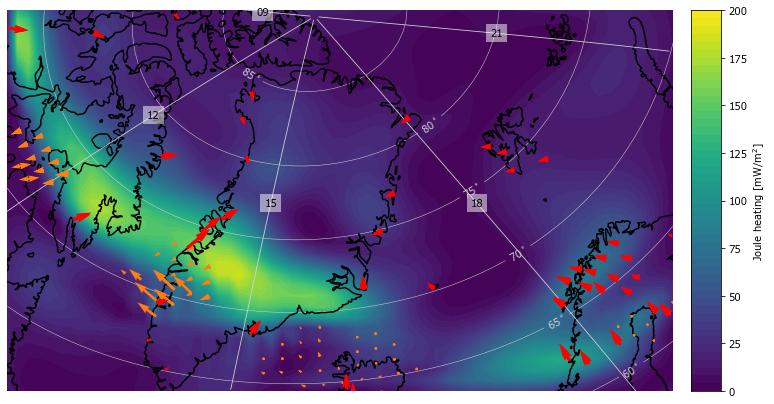

In [14]:
# lompe model currents and electric field
Je, Jn = model.j()
Ee, En = model.E()

# modelled joule heating
W = Je * Ee + Jn * En
total_heating_rate = np.sum(model.A.dot(W) )*1e-9 # GW
print('Total Joule heating rate is %.2f GW.' % total_heating_rate )

# plot joule heating on part of model grid
figJ = plt.figure(figsize = (13, 7))

ax1 = plt.subplot2grid((1, 20), (0, 0 ), colspan = 19)
axc = plt.subplot2grid((1, 20), (0, 19))

# add coastlines
visualization.format_ax(ax1, model, apex = a)
visualization.plot_coastlines(ax1, model, resolution = '50m')

# joule heating contours
lvls = np.linspace(0, .2, 50)*1000
ax1.contourf(grid.xi, grid.eta, W.reshape(grid.shape)*1000, levels = lvls)

# model convection at SuperDARN backscatter sites in orange
visualization.plot_datasets(ax1, model, dtype = 'convection', zorder = 3)

# model magnetic field disturbance on ground at SuperMAG sites in red
visualization.plot_datasets(ax1, model, dtype = 'ground_mag', color = 'red', zorder = 3)

# adjust plots, add grids and titles
visualization.plot_mlt(ax1, model, t0, a, mltlevels = np.array([9, 12, 15, 18, 21]), color = 'lightgrey', linewidth = .8)

# color bar
axc.contourf(np.vstack((np.zeros(50), np.ones(50))).T, np.vstack((lvls, lvls)).T, np.vstack((lvls, lvls)).T, levels = lvls)

axc.set_ylabel('Joule heating [mW/m$^2$]')

axc.yaxis.set_label_position('right')
axc.yaxis.tick_right()
axc.set_xticks([])

# save figure
figJ.savefig('output_figures/hilda_event_Joule_heating.png', dpi = 200)

The figure shows Joule heating on the colour scale. The orange arrows are the modelled convection at the locations of SuperDARN input data. The red arrows are modelled magnetic field perturbations on ground at the SuperMAG sites providing input data.